# Exploratory Data Analysis (EDA) of Spotify Data Over Time
## Ange Olson

Since April of 2016, I've made (almost) monthly playlists on Spotify consisting of the songs I enjoyed listening to that month. I created them as the month went on, meaning they've got a couple of cool characteristics:

* They can be used to see which artist/genres I was listening to together at any given time
* They provide point-in-time stats rather than the short-term, medium-term, and long-term song histories directly available from the API 
* They can more accurately be used to determine songs I particularly liked than looking at the songs I listened to frequently, and compared to the songs I listened to that didn't end up on a playlist (read: content-based recommendation system)

I've gone through and pulled the data from all the playlists, grabbing the typical metadata on each song (see the [Spotify Documentation on audio features](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features) for a full list and descriptions) including artist name, genre, release year, valence, tempo, key, etc. I was able to use the name of the playlist itself, dated almost uniformly throughout the past 6 years, to grab the month and year I listened to the song. 

In the analysis below, I mostly focus on either month trends for all years, or trends over the past 6 years rather than analyzing the data as a whole. 

# Section I: Basic Info 
##### How many observations do I have? How many months am I missing? How balanced is the dataset? 

Before getting started, I want to see how many observations of months I have (for lookng at trends across a year) and how many observations I have per month. In short, I don't have a perfectly balanced dataset, with x songs per month and y observations of each month. It's good to know going in to know which montsh I have fewer data points on, what dates my time series is skipping over, and how I'll need to handle some of the stats I plan to look at.

In [1]:
# import packages, data, set theme 

# packages
from matplotlib import markers
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats 
import statistics
import plotly.express as px
import statsmodels 

# graphing
sns.set_theme(style="whitegrid", palette="Paired")

# data
df = pd.read_csv("time_series_data_clean.csv")

In [2]:
# define pivot table function and use to create main dataframes

# get vals that need to be averaged
mean_vals = "danceability", "energy", "loudness", "speechiness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "track_pop", "artist_pop", "release_year"

# get vals for mode
mode_vals = "key", "mode", "time_signature", "artist_genre", "artist"

def getPivot(mean_vals, mode_vals, index):
    
    # define pivot table of means
    table_means = pd.pivot_table(df, index = index, values = mean_vals, aggfunc=np.mean)
    
    # define pivot table of modes
    table_modes = pd.pivot_table(df, index = index, values = mode_vals, aggfunc=statistics.mode)

    pivot_df = table_means.join(table_modes, on=index)
    pivot_df.reset_index(inplace=True)
    pivot_df = pivot_df.rename(columns = {'index': index})

    return pivot_df

# create pivot table by date
# get index val
index = "playlist_date"

datePivot = getPivot(mean_vals=mean_vals, mode_vals=mode_vals, index=index)

datePivot["playlist_date"] = pd.to_datetime(datePivot.playlist_date)

# create pivot table by month
# get index val
index2 = "playlist_month"

monthPivot = getPivot(mean_vals=mean_vals, mode_vals=mode_vals, index=index2)

The months with the lowest number of observations are June and August (2), but all months have at least one observation.

In [3]:
month_counts = df.groupby('playlist_month')['playlist_date'].nunique()
print(month_counts)

playlist_month
1     4
2     4
3     3
4     6
5     4
6     2
7     4
8     2
9     3
10    3
11    3
12    3
Name: playlist_date, dtype: int64


In [4]:
# Calculate artist variance, genre variance in playlists, total number of tracks to normalize by date
dateArtVariance = df.groupby('playlist_date')['artist'].nunique()
dateGenVariance = df.groupby('playlist_date')['artist_genre'].nunique()
dateTrackCount = df.groupby('playlist_date')['track_name'].nunique()

# normalization: 
# artist: if 1, artist to track ratio is 1:1 (i.e. each artist has one track). The lower the number, the more times you're listening to songs by the same artist. 
# genre: if 1, every song has a different genre. The lower the number, the more similar in genre each playlist is. 

dateArtVarNorm = dateArtVariance/dateTrackCount
dateGenVarNorm = dateGenVariance/dateTrackCount

In [5]:
# Calculate artist variance, genre variance in playlists, total number of tracks to normalize by month
monthArtVariance = df.groupby('playlist_month')['artist'].nunique()
monthGenVariance = df.groupby('playlist_month')['artist_genre'].nunique()
monthTrackCount = df.groupby('playlist_month')['track_name'].nunique()

# normalization: if 1, artist to track ratio is 1:1 (i.e. each artist has one track). The lower the number, the more times you're listening to songs by the same artist. 

monthArtVarNorm = monthArtVariance/monthTrackCount
monthGenVarNorm = monthGenVariance/monthTrackCount

The total number of tracks also varies by month, also in the same trend as above.

In [6]:
print(monthTrackCount)

playlist_month
1     126
2     132
3     126
4     171
5     133
6      28
7     119
8      63
9      83
10     69
11    132
12     64
Name: track_name, dtype: int64


The average number of tracks varies less; June still has the lowest average number of tracks per month, while November and March have the two highest.

In [7]:
print(monthTrackCount/month_counts)

playlist_month
1     31.500000
2     33.000000
3     42.000000
4     28.500000
5     33.250000
6     14.000000
7     29.750000
8     31.500000
9     27.666667
10    23.000000
11    44.000000
12    21.333333
dtype: float64


The number of tracks per point in time predictably changes, but recently the range of playlist size seems to have leveleled out some, with playlists looking shorter on average. 

playlist_date
2016-04-01    23
2016-07-01    76
2017-04-01    48
2017-07-01     9
2017-09-01    45
2017-11-01    94
2018-01-01    43
2018-02-01    29
2018-03-01    42
2018-04-01    17
2018-05-01     4
2018-10-01    35
2018-11-01    23
2018-12-01    18
2019-02-01    22
2019-09-01    21
2020-01-01    27
2020-04-01    48
2020-05-01    70
2020-07-01    14
2020-08-01    45
2020-10-01     7
2020-12-01    15
2021-01-01    14
2021-02-01    53
2021-03-01    52
2021-04-01    13
2021-05-01    36
2021-06-01    13
2021-07-01    21
2021-08-01    18
2021-09-01    17
2021-10-01    27
2021-11-01    16
2021-12-01    31
2022-01-01    44
2022-02-01    28
2022-03-01    32
2022-04-01    23
2022-05-01    23
2022-06-01    15
Name: track_name, dtype: int64


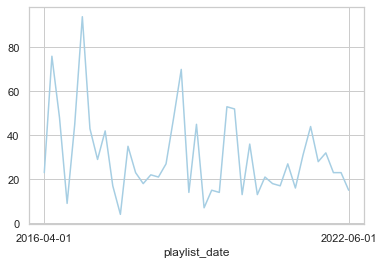

In [25]:
print(dateTrackCount)
sns.lineplot(y=dateTrackCount.values, x=dateTrackCount.index)
plt.xticks(['2016-04-01', '2022-06-01'])
plt.show()

Because of this, for any analysis related to top artists, or top genres, I'll be focusing on the proportion rather than the raw coutn to try and normalize the data. 

In [9]:
# merge artist variance to pivot tables above 

# Step 1: create dataframe for the date grouping
d = {'artist_variance': dateArtVariance, 'genre_variance': dateGenVariance, 'track_count': dateTrackCount, 'norm_artist_variance': dateArtVarNorm, 'norm_gen_variance': dateGenVarNorm}

dateDf = pd.DataFrame(d)
dateDf.reset_index(inplace=True)
dateDf = dateDf.rename(columns = {'index': index})
dateDf['playlist_date'] = pd.to_datetime(dateDf.playlist_date)

# merge dataframes
datePivot = dateDf.merge(datePivot, on='playlist_date')

# Step 2: create dataframe for month grouping 
m = {'artist_variance': monthArtVariance, 'genre_variance': monthGenVariance, 'track_count': monthTrackCount, 'norm_artist_variance': monthArtVarNorm, 'norm_gen_variance': monthGenVarNorm}

monthDf = pd.DataFrame(m)
monthDf.reset_index(inplace=True)
monthDf = monthDf.rename(columns = {'index': index})

# merge
monthPivot = monthDf.merge(monthPivot, on='playlist_month')

# Section II: Basic Graphs and Tables
##### How does the average of the continuous variables I have change over time? By month? What about top artist or top genre? 

First, I look at plots over time (with smoothing) for the average of the various continous variables. Of note, it looks like recently (since 2020) the music I've been listening to is more danceable, more energetic, louder, more instrumental, less speechy (read: rap), more live, more recent, more popular (track-wise) and less popular (artist-wise). 

In [10]:
# plots based on date

for y in mean_vals:
    fig = px.scatter(datePivot, x="playlist_date", y=y, title=f"{y} Over Time", height=500, width=500, trendline="lowess", trendline_options=dict(frac=0.5))
    fig.show()

Next, I look at monthly trends. Overall:

* Where danceability, is concerned, it looks like in the spring I listen to less danceabile music 
* Energy and loudness both peak in the summer 
* Speechiness goes down and instrumentalness up as the year progresses 
* Liveness, valence, and tempo drop in the fall and peak bakc up again in the winter 
* Duration drops in the winter
* Track popularity remains relatively constant, while artist popularity drops in the spring and increases in the winter 
* Lastly, release year looks to drop in the spring and increase throughout the year from there

In [11]:
# plots based on month 
for y in mean_vals:
    fig = px.scatter(monthPivot, x="playlist_month", y=y,title=f"{y} By Month", height=500, width=500, trendline="lowess", trendline_options=dict(frac=0.5))
    fig.show()

There are a couple of graphs that are particualrly interesting to plot together. One is comparing the trends of artist vs. song popularity over time, where as time has gone on I am now listening to artists and tracks that are more similar in popularity, and that I'm listening to more obscure artists (but maybe their more popular tracks). Additionally, the trend of listening to more popular tracks started before I listened to less popular artists. 

In [12]:
# plot popularity over time together 
y = ['artist_pop', 'track_pop']

fig = px.scatter(datePivot, x="playlist_date", y=y, title="Artist and Track Popularity Over Time", height=500, width=500, trendline="lowess", trendline_options=dict(frac=0.5)).update_layout(xaxis_title="Date", yaxis_title="Average Score")
fig.show()


As well as valence and danceability over time, where we can see the two move together over time. 

In [13]:
# plot valence and energy over time together 
y = ['valence', 'danceability']

fig = px.scatter(datePivot, x="playlist_date", y=y, title="Valence and Danceability Over Time", height=500, width=500, trendline="lowess", trendline_options=dict(frac=0.5)).update_layout(xaxis_title="Date", yaxis_title="Average Score")
fig.show()